# GAME OF THRONES Death Prediction

## Model Analysis

This sript will retrieve information from the .csv file saved on step 1 ([Load&Clean data](01_LoadClean_data.ipynb)) and genertate different Prediction Models on the data, both books and books+show information, to find the best fit.

If step 0 ([Load&Clean data](01_LoadClean_data.ipynb)) has already been executed **once** it will not be necessary to execute it again and you can start from here.

In [1]:
#Library Section
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from collections import Counter
from sklearn import model_selection
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
#from imblearn.over_sampling import SMOTE 

C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


**Graphic Functions**

In [51]:
def plot_confussion_matrix(title,model,xtrain,ytrain, xtest, ytest):

    # accuracy for test & train:
    train_acc=model.score(xtrain, ytrain)
    test_acc=model.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = model.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
    print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
    cm=confusion_matrix(y_true, y_pred)
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Reds)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def plot_roc_curve(model, x_test, y_test):
    y_score=model.predict_proba(x_test)[:,1]

    fpr, tpr,_ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    # Plotting our Baseline..
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr,color='green')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve (AUC = ' + str(roc_auc)+ ')')

In [55]:
def plot_precition_recall(model, x_test, y_test) :
    y_score = model.predict_proba(x_test)[:,1]
    p,r,t = precision_recall_curve(y_test,y_score)

    # adding last threshold of '1' to threshold list
    t=np.vstack([t.reshape([-1,1]),1])

    plt.title('Precision Recall Curve', color='white')
    plt.plot(t,p, label='Precision')
    plt.plot(t,r, label='Recall')
    plt.xticks(color='white')
    plt.yticks(color='white')
    plt.legend()
    plt.grid()


## Analysis on INNER JOIN
**Characters that appear both in the Book and in the Tv Show**

In [18]:
got_df = pd.read_csv('csv/SQLINNER_GOT_data.csv')
len(got_df)

115

In [6]:
#Personajes que estan muertos pero aaprecen vivos en el dataset
deads6_list = ['Grenn', 'Janos Slynt', 'Doreah', 'Mace Tyrell', 'Brynden Tully', 'Xaro Xhoan Daxos', 'Kevan Lannister']
got_df['isdead_shw'][got_df['name_x'].isin(deads6_list)] = 1

len(got_df)

C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


115

In [50]:
got_df[got_df.name_x == 'Lyanna Mormont'][['name_x','isdead_shw']]

,name_x,isdead_shw
1075,Lyanna Mormont,0.0


In [19]:
y = got_df['isdead_shw']
x = got_df[['isdead_bk', 'ismale', 'book1', 'book2', 'book3', 'book4', 'book5',
            #'isalivemother_bk', 'isalivefather_bk', 'isaliveheir_bk','isalivespouse_bk', 'ismarried_bk', 
            'isnoble_bk', 'booldeadrelations_bk', 'ispopular_bk', #'death_bk', 'apperance_chp',
            #'hasmom_bk', 'hasdad_bk', 'hasheir_bk', 'hasspouse_bk', 
            'age_bk', 'numdeadrelations_bk', 'popularity_bk', 
            #'culture_bk', 'house_bk', 'name_y', 'isdead_shw', 'death_season', 
            'time_s1', 'time_s2', 'time_s3', 'time_s4', #'total_episode_num', 
            'season1', 'season2', 'season3', 'season4', 'age_shw', #'house_shw', 'match_name',
            #'sum_rating', 'total_viewers',
            'culture_bk[T.Astap]', 'culture_bk[T.Braav]', 'culture_bk[T.Crann]', 'culture_bk[T.Dorni]', 
            'culture_bk[T.Dothr]', 'culture_bk[T.Free ]', 'culture_bk[T.Ghisc]', 'culture_bk[T.Ironb]', 
            'culture_bk[T.Ironm]', 'culture_bk[T.Lhaza]', 'culture_bk[T.Lysen]', 'culture_bk[T.Myris]', 
            'culture_bk[T.Naath]', 'culture_bk[T.None]', 'culture_bk[T.North]', 'culture_bk[T.Pento]', 
            'culture_bk[T.Qarth]', 'culture_bk[T.Reach]', 'culture_bk[T.River]', 'culture_bk[T.Storm]', 
            'culture_bk[T.The R]', 'culture_bk[T.Tyros]', 'culture_bk[T.Valem]', 'culture_bk[T.Valyr]', 
            'culture_bk[T.Weste]', 'culture_bk[T.Wildl]',
            'house_bk[T.BROTHERHOOD WITHOUT BANNERS]', 'house_bk[T.HOUSE ARRYN]', 'house_bk[T.HOUSE BAELISH]', 
            'house_bk[T.HOUSE BARATHEON]', 'house_bk[T.HOUSE BOLTON]', 'house_bk[T.HOUSE CLEGANE]', 
            'house_bk[T.HOUSE FREY]', 'house_bk[T.HOUSE GREYJOY]', 'house_bk[T.HOUSE LANNISTER]', 
            'house_bk[T.HOUSE MARTELL]', 'house_bk[T.HOUSE STARK]', 'house_bk[T.HOUSE TARGARYEN]', 
            'house_bk[T.HOUSE TULLY]', 'house_bk[T.HOUSE TYRELL]', 'house_bk[T.NIGHTS WATCH]', 'house_bk[T.OTHER]', 
            'house_bk[T.UNKNOWN]', 'house_shw[T.House Bolton]', 'house_shw[T.House Greyjoy]', 
            'house_shw[T.House Lannister]', 'house_shw[T.House Stark]', 'house_shw[T.House Targaryen]', 
            'house_shw[T.None]', 'house_shw[T.Nights Watch]']]
len(x)

115

In [20]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.30, random_state=4444, stratify=y)

In [21]:
print('Original dataset train {}'.format(Counter(y_train)))
print('Original dataset test {}'.format(Counter(y_test)))

Original dataset train Counter({1: 45, 0: 35})
Original dataset test Counter({1: 20, 0: 15})


In [104]:
#Se inicializa una lista en donde se incluiran todos los modelos
modelos = []

### kNN Model

In [105]:
best_k = 1
max_score = 0

for k in range(1,51) :
    model = KNeighborsClassifier(k)
    model.fit(x_train, y_train)
    current_score = accuracy_score(y_test, model.predict(x_test))
    if current_score > max_score :
        max_score = current_score
        best_k = k
print('Best k: ' + str(best_k) + '  (Score = ' + str(max_score) + ')')

Best k: 5  (Score = 0.84)


In [106]:
knn_model = KNeighborsClassifier(best_k)
knn_model.fit(x_train, y_train)
knn_model.score(x_test, y_test)

0.84

C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.84      1.00      0.91        21

avg / total       0.71      0.84      0.77        25

Training Data Accuracy: 0.86
Test Data Accuracy:     0.84
[[ 0  4]
 [ 0 21]]


Precision:              0.84
Recall:                 1.00


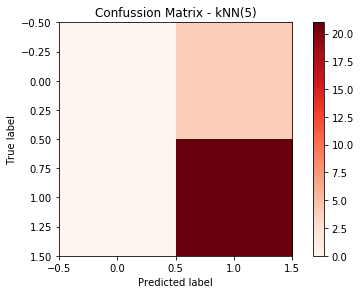

In [107]:
print(classification_report(y_test, knn_model.predict(x_test)))
plot_confussion_matrix('Confussion Matrix - kNN('+ str(best_k) +')', knn_model, x_train, y_train, x_test, y_test)
#plt.savefig('kNN_ConfussionMat.png')

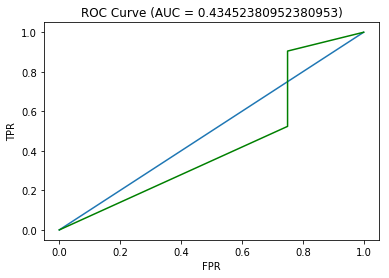

In [108]:
plot_roc_curve(knn_model, x_test, y_test)

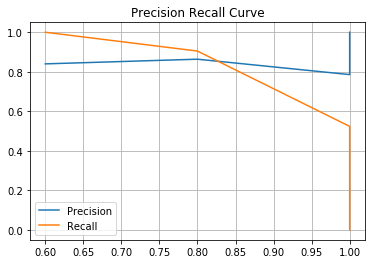

In [109]:
plot_precition_recall(knn_model,x_test, y_test)

In [110]:
knn_model.name='Knn_13_show'
with open("models/inner_knn13.pkl", "wb") as f:
    pickle.dump(knn_model, f)
    
modelos.append(knn_model)

### Logistic Regression (Unbalanced)

In [22]:
log_model = LogisticRegression()
log_model.fit(x_train, y_train)
log_model.score(x_test, y_test)

0.7142857142857143

             precision    recall  f1-score   support

          0       0.73      0.53      0.62        15
          1       0.71      0.85      0.77        20

avg / total       0.72      0.71      0.71        35

Training Data Accuracy: 0.86
Test Data Accuracy:     0.71
[[ 8  7]
 [ 3 17]]


Precision:              0.71
Recall:                 0.85


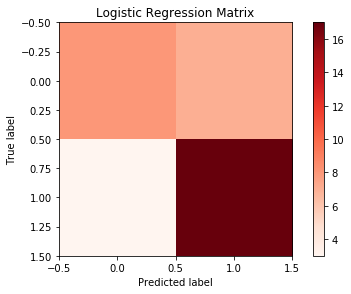

In [52]:
print(classification_report(y_test, log_model.predict(x_test)))
plot_confussion_matrix('Logistic Regression Matrix', log_model, x_train, y_train, x_test, y_test)

**Grid Search**

In [24]:
param_grid = {
    "C": np.logspace(2,-5,10)
}

rbf_grid = model_selection.RandomizedSearchCV(log_model, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=5)

In [25]:
rbf_grid.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   0.0s
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   0.0s
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   0.0s
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   0.0s
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   0.0s
[CV] C=0.46415888336127775 ...........................................
[CV] ............................ C=0.46415888336127775, total=   0.0s
[CV] C=0.46415888336127775 ...........................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [26]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")


best params: {'C': 0.46415888336127775}
best score: 0.6875



In [27]:
log_model = rbf_grid.best_estimator_
log_model.fit(x_train,y_train)
log_model.score(x_test, y_test)

0.7142857142857143

             precision    recall  f1-score   support

          0       0.73      0.53      0.62        15
          1       0.71      0.85      0.77        20

avg / total       0.72      0.71      0.71        35

Training Data Accuracy: 0.86
Test Data Accuracy:     0.71
[[ 8  7]
 [ 3 17]]


Precision:              0.71
Recall:                 0.85


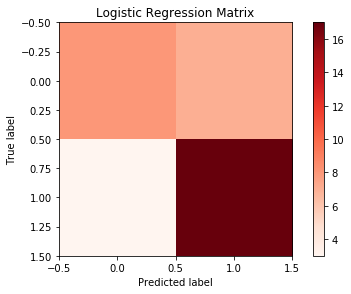

In [28]:
print(classification_report(y_test, log_model.predict(x_test)))
plot_confussion_matrix('Logistic Regression Matrix', log_model, x_train, y_train, x_test, y_test)

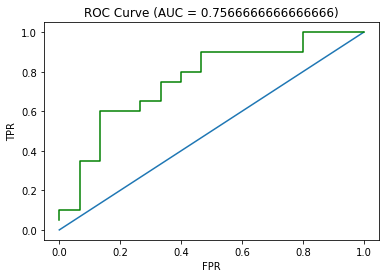

In [29]:
plot_roc_curve(log_model, x_test, y_test)

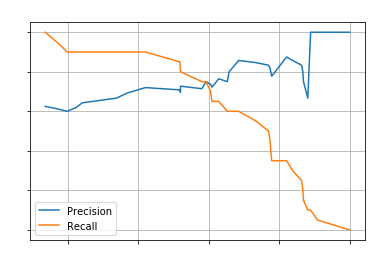

In [56]:
plot_precition_recall(log_model, x_test, y_test)

In [32]:
log_model.name = 'RegLog_show'
with open("models/inner_reglog.pkl", "wb") as f:
    pickle.dump(log_model, f)

modelos.append(log_model)

# Logistic Regression (Balanced)

In [121]:
bal_model = LogisticRegression(class_weight='balanced')
bal_model.fit(x_train, y_train)
bal_model.score(x_test, y_test)

0.68

**Grid Search**

In [122]:
param_grid = {
    "C": np.logspace(2,-5,10)
}

rbf_grid = model_selection.RandomizedSearchCV(bal_model, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=5)

In [123]:
rbf_grid.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=5.994842503189409e-05 .........................................
[CV] .......................... C=5.994842503189409e-05, total=   0.0s
[CV] C=5.994842503189409e-05 .........................................
[CV] .......................... C=5.994842503189409e-05, total=   0.0s
[CV] C=5.994842503189409e-05 .........................................
[CV] .......................... C=5.994842503189409e-05, total=   0.0s
[CV] C=5.994842503189409e-05 .........................................
[CV] .......................... C=5.994842503189409e-05, total=   0.0s
[CV] C=5.994842503189409e-05 .........................................
[CV] .......................... C=5.994842503189409e-05, total=   0.0s
[CV] C=2.7825594022071245 ............................................
[CV] ............................. C=2.7825594022071245, total=   0.0s
[CV] C=2.7825594022071245 ............................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................. C=0.0774263682681127, total=   0.0s
[CV] C=0.0774263682681127 ............................................
[CV] ............................. C=0.0774263682681127, total=   0.0s
[CV] C=0.0774263682681127 ............................................
[CV] ............................. C=0.0774263682681127, total=   0.0s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [124]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")


best params: {'C': 2.7825594022071245}
best score: 0.7586206896551724



In [125]:
bal_model = rbf_grid.best_estimator_
bal_model.fit(x_train,y_train)
bal_model.score(x_test, y_test)

0.68

In [126]:
print(classification_report(y_test, bal_model.predict(x_test)))

             precision    recall  f1-score   support

          0       0.17      0.25      0.20         4
          1       0.84      0.76      0.80        21

avg / total       0.73      0.68      0.70        25



Training Data Accuracy: 1.00
Test Data Accuracy:     0.68
[[ 1  3]
 [ 5 16]]


Precision:              0.84
Recall:                 0.76


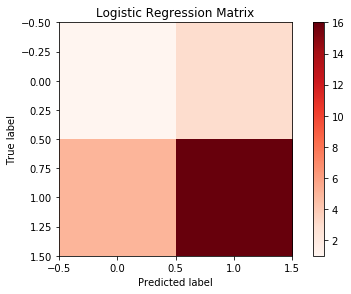

In [127]:
plot_confussion_matrix('Logistic Regression Matrix', bal_model, x_train, y_train, x_test, y_test)

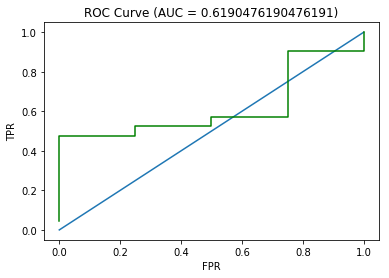

In [128]:
plot_roc_curve(bal_model, x_test, y_test)

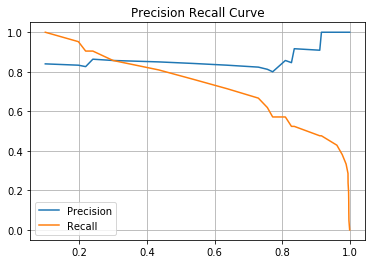

In [129]:
plot_precition_recall(bal_model, x_test, y_test)

In [130]:
bal_model.name = 'LogBal_show'
with open("models/inner_balanced_cht.pkl", "wb") as f:
    pickle.dump(bal_model, f)
modelos.append(bal_model)

## SVM Model (Lineal)

In [131]:
svm_model = svm.SVC(kernel='linear', probability=True)
svm_model.fit(x_train, y_train)
svm_model.score(x_test, y_test)

0.72

**Grid Search**

In [132]:
param_grid = {
    "C": np.logspace(2, -5, 10),
    "gamma": np.logspace(1, -5, 10),
}

rbf_grid = model_selection.RandomizedSearchCV(
    svm_model, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=2)

In [133]:
rbf_grid.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] gamma=0.464158883361278, C=5.994842503189409e-05 ................
[CV] . gamma=0.464158883361278, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.464158883361278, C=5.994842503189409e-05 ................
[CV] . gamma=0.464158883361278, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.464158883361278, C=5.994842503189409e-05 ................
[CV] . gamma=0.464158883361278, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.464158883361278, C=5.994842503189409e-05 ................
[CV] . gamma=0.464158883361278, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.464158883361278, C=5.994842503189409e-05 ................
[CV] . gamma=0.464158883361278, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.1, C=2.7825594022071245 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................. gamma=0.1, C=2.7825594022071245, total=  26.9s
[CV] gamma=0.1, C=2.7825594022071245 .................................
[CV] .................. gamma=0.1, C=2.7825594022071245, total=  16.5s
[CV] gamma=0.1, C=2.7825594022071245 .................................
[CV] .................. gamma=0.1, C=2.7825594022071245, total=  30.4s
[CV] gamma=0.1, C=2.7825594022071245 .................................
[CV] .................. gamma=0.1, C=2.7825594022071245, total= 1.3min
[CV] gamma=0.1, C=2.7825594022071245 .................................
[CV] .................. gamma=0.1, C=2.7825594022071245, total=  37.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=2, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05]), 'gamma': array([1.00000e+01, 2.15443e+00, 4.64159e-01, 1.00000e-01, 2.15443e-02,
       4.64159e-03, 1.00000e-03, 2.15443e-04, 4.64159e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [134]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")
rbf_grid.best_params_


best params: {'gamma': 0.464158883361278, 'C': 5.994842503189409e-05}
best score: 0.8103448275862069



{'gamma': 0.464158883361278, 'C': 5.994842503189409e-05}

In [135]:
svm_model = rbf_grid.best_estimator_
svm_model.fit(x_train,y_train)
svm_model.score(x_test, y_test)

0.84

C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.84      1.00      0.91        21

avg / total       0.71      0.84      0.77        25

Training Data Accuracy: 0.84
Test Data Accuracy:     0.84
[[ 0  4]
 [ 0 21]]


Precision:              0.84
Recall:                 1.00


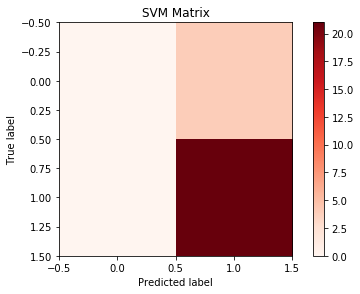

In [136]:
print(classification_report(y_test, svm_model.predict(x_test)))
plot_confussion_matrix('SVM Matrix', svm_model, x_train, y_train, x_test, y_test)

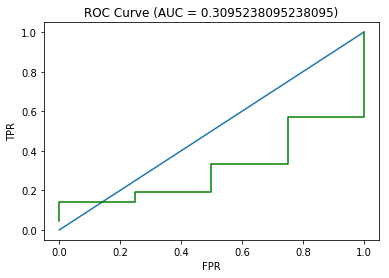

In [137]:
plot_roc_curve(svm_model, x_test, y_test)

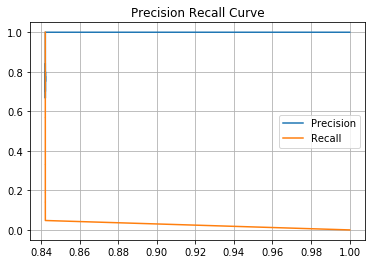

In [138]:
plot_precition_recall(svm_model, x_test, y_test)

In [139]:
svm_model.name = 'svmlin_show'
modelos.append(svm_model)

## SVM Model (RBF Kernell)

In [140]:
rbf_svm = svm.SVC(kernel='rbf', probability=True)
rbf_svm.fit(x_train, y_train)
rbf_svm.score(x_test, y_test)

0.84

In [141]:
param_grid = {
    "C": np.logspace(2,-5,10),
    "gamma": np.logspace(1,-5,10),
}

rbf_grid = model_selection.RandomizedSearchCV(rbf_svm, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=5)

In [142]:
rbf_grid.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] gamma=0.001, C=0.0774263682681127 ...............................
[CV] ................ gamma=0.001, C=0.0774263682681127, total=   0.0s
[CV] gamma=0.001, C=0.0774263682681127 ...............................
[CV] ................ gamma=0.001, C=0.0774263682681127, total=   0.0s
[CV] gamma=0.001, C=0.0774263682681127 ...............................
[CV] ................ gamma=0.001, C=0.0774263682681127, total=   0.0s
[CV] gamma=0.001, C=0.0774263682681127 ...............................
[CV] ................ gamma=0.001, C=0.0774263682681127, total=   0.0s
[CV] gamma=0.001, C=0.0774263682681127 ...............................
[CV] ................ gamma=0.001, C=0.0774263682681127, total=   0.0s
[CV] gamma=0.00021544346900318867, C=5.994842503189409e-05 ...........
[CV]  gamma=0.00021544346900318867, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.00021544346900318867, C=5.994842503189409e-05 ...........
[CV]  gamma=0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05]), 'gamma': array([1.00000e+01, 2.15443e+00, 4.64159e-01, 1.00000e-01, 2.15443e-02,
       4.64159e-03, 1.00000e-03, 2.15443e-04, 4.64159e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [143]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")
rbf_grid.best_params_


best params: {'gamma': 0.001, 'C': 0.0774263682681127}
best score: 0.8448275862068966



{'gamma': 0.001, 'C': 0.0774263682681127}

In [144]:
rbf_svm = rbf_grid.best_estimator_
rbf_svm.fit(x_train,y_train)
rbf_svm.score(x_test, y_test)

0.84

In [145]:
print(classification_report(y_test, rbf_svm.predict(x_test)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.84      1.00      0.91        21

avg / total       0.71      0.84      0.77        25



C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training Data Accuracy: 0.84
Test Data Accuracy:     0.84
[[ 0  4]
 [ 0 21]]


Precision:              0.84
Recall:                 1.00


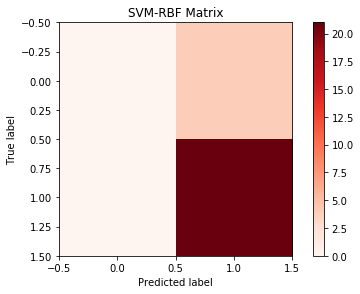

In [146]:
plot_confussion_matrix('SVM-RBF Matrix', rbf_svm, x_train, y_train, x_test, y_test)

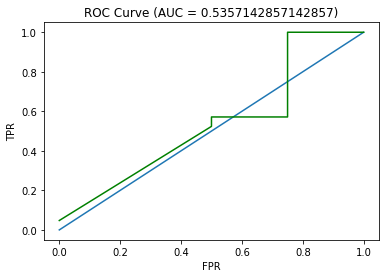

In [147]:
plot_roc_curve(rbf_svm, x_test, y_test)

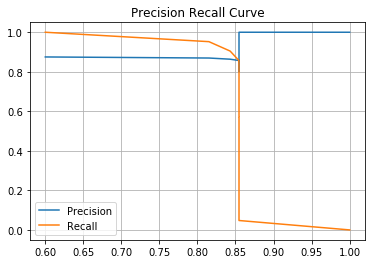

In [148]:
plot_precition_recall(rbf_svm, x_test, y_test)

In [149]:
rbf_svm.name = 'SvmRbf_show'
with open("models/inner_svm_rbf_cht.pkl", "wb") as f:
    pickle.dump(rbf_grid, f)
modelos.append(rbf_svm)

## SVM Model (Polynomial Kernell)

In [150]:
poly_svm = svm.SVC(kernel='poly', probability=True)
poly_svm.fit(x_train, y_train)
poly_svm.score(x_test, y_test)

0.8

**Grid Search**

In [151]:
param_grid = {
    "C": np.logspace(2,-5,10),
    "gamma": np.logspace(1,-5,10),
}

rbf_grid = model_selection.RandomizedSearchCV(poly_svm, param_grid, verbose=2, n_jobs=1, cv=3, n_iter=5)

In [152]:
rbf_grid.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] gamma=0.1, C=100.0 ..............................................
[CV] ............................... gamma=0.1, C=100.0, total=   0.0s
[CV] gamma=0.1, C=100.0 ..............................................
[CV] ............................... gamma=0.1, C=100.0, total=   0.0s
[CV] gamma=0.1, C=100.0 ..............................................
[CV] ............................... gamma=0.1, C=100.0, total=   0.0s
[CV] gamma=0.1, C=16.68100537200059 ..................................
[CV] ................... gamma=0.1, C=16.68100537200059, total=   0.0s
[CV] gamma=0.1, C=16.68100537200059 ..................................
[CV] ................... gamma=0.1, C=16.68100537200059, total=   0.0s
[CV] gamma=0.1, C=16.68100537200059 ..................................
[CV] ................... gamma=0.1, C=16.68100537200059, total=   0.0s
[CV] gamma=0.464158883361278, C=0.01291549665014884 ..................
[CV] ... gamma=0.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] gamma=0.004641588833612782, C=100.0 .............................
[CV] .............. gamma=0.004641588833612782, C=100.0, total=   0.0s
[CV] gamma=0.464158883361278, C=0.0774263682681127 ...................
[CV] .... gamma=0.464158883361278, C=0.0774263682681127, total=   0.0s
[CV] gamma=0.464158883361278, C=0.0774263682681127 ...................
[CV] .... gamma=0.464158883361278, C=0.0774263682681127, total=   0.0s
[CV] gamma=0.464158883361278, C=0.0774263682681127 ...................
[CV] .... gamma=0.464158883361278, C=0.0774263682681127, total=   0.0s


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05]), 'gamma': array([1.00000e+01, 2.15443e+00, 4.64159e-01, 1.00000e-01, 2.15443e-02,
       4.64159e-03, 1.00000e-03, 2.15443e-04, 4.64159e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [153]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")
rbf_grid.best_params_


best params: {'gamma': 0.1, 'C': 100.0}
best score: 0.6724137931034483



{'gamma': 0.1, 'C': 100.0}

In [154]:
poly_svm = rbf_grid.best_estimator_
poly_svm.fit(x_train,y_train)
poly_svm.score(x_test, y_test)

0.8

In [155]:
print(classification_report(y_test, poly_svm.predict(x_test)))

             precision    recall  f1-score   support

          0       0.33      0.25      0.29         4
          1       0.86      0.90      0.88        21

avg / total       0.78      0.80      0.79        25



Training Data Accuracy: 1.00
Test Data Accuracy:     0.80
[[ 1  3]
 [ 2 19]]


Precision:              0.86
Recall:                 0.90


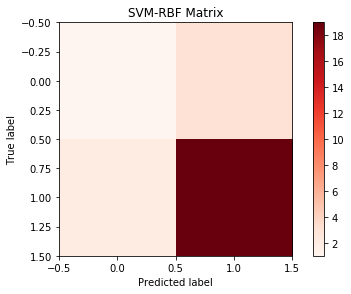

In [156]:
plot_confussion_matrix('SVM-RBF Matrix', poly_svm, x_train, y_train, x_test, y_test)

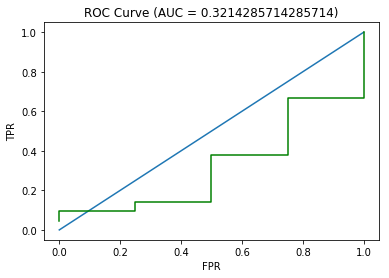

In [157]:
plot_roc_curve(poly_svm, x_test, y_test)

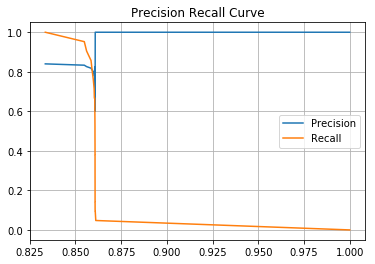

In [158]:
plot_precition_recall(poly_svm, x_test, y_test)

In [159]:
poly_svm.name = 'SvmPoly_show'
modelos.append(poly_svm)

## Decision Tree Model

In [160]:
from sklearn.tree import DecisionTreeClassifier

best_depth = 1
max_score = 0

for d in range(3,50) :
    tree_model = DecisionTreeClassifier(max_depth=d, )
    tree_model.fit(x_train, y_train)
    current_score = accuracy_score(y_test, tree_model.predict(x_test))
    if current_score > max_score :
        max_score = current_score
        best_depth = d
print('Best Depth: ' + str(best_depth) + '  (Score = ' + str(max_score) + ')')


Best Depth: 7  (Score = 0.88)


In [161]:
tree_model = DecisionTreeClassifier(max_depth=best_depth)
tree_model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [162]:
print(classification_report(y_test, tree_model.predict(x_test)))

             precision    recall  f1-score   support

          0       1.00      0.25      0.40         4
          1       0.88      1.00      0.93        21

avg / total       0.90      0.88      0.85        25



Training Data Accuracy: 0.98
Test Data Accuracy:     0.88
[[ 1  3]
 [ 0 21]]


Precision:              0.88
Recall:                 1.00


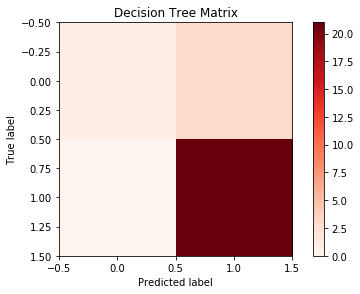

In [163]:
plot_confussion_matrix('Decision Tree Matrix', tree_model, x_train, y_train, x_test, y_test)

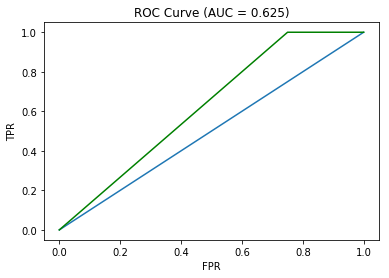

In [164]:
plot_roc_curve(tree_model, x_test, y_test)

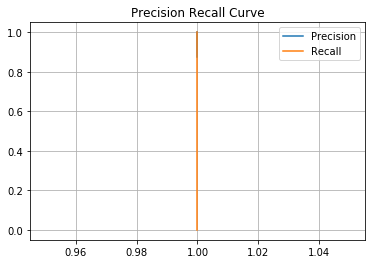

In [165]:
plot_precition_recall(tree_model, x_test, y_test)

In [166]:
tree_model.name = 'tree_show'
modelos.append(tree_model)

In [261]:
with open("models/inner_tree_cht.pkl", "wb") as f:
    pickle.dump(tree_model, f)

## Random Forest Model

In [167]:
from sklearn.ensemble import RandomForestClassifier

best_depth = 1
max_score = 0

for d in range(1,50) :
    forest_model = RandomForestClassifier(max_depth=d, max_features=None, n_estimators=30)
    forest_model.fit(x_train, y_train)
    #current_score = accuracy_score(y_test, forest_model.predict(x_test))
    current_score = forest_model.score(x_test,y_test)
    if current_score > max_score :
        max_score = current_score
        best_depth = d
        best_model = forest_model
print('Best Depth: ' + str(best_depth) + '  (Score = ' + str(max_score) + ')')

Best Depth: 1  (Score = 0.84)


In [168]:
forest_model = best_model
#forest_model = RandomForestClassifier(max_depth=best_depth, max_features=None, n_estimators=30)
#forest_model.fit(x_train, y_train)
#forest_model.score(x_test,y_test)

In [169]:
print(classification_report(y_test, forest_model.predict(x_test)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.84      1.00      0.91        21

avg / total       0.71      0.84      0.77        25



C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training Data Accuracy: 0.86
Test Data Accuracy:     0.84
[[ 0  4]
 [ 0 21]]


Precision:              0.84
Recall:                 1.00


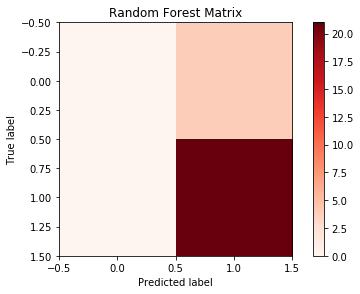

In [170]:
plot_confussion_matrix('Random Forest Matrix', forest_model, x_train, y_train, x_test, y_test)

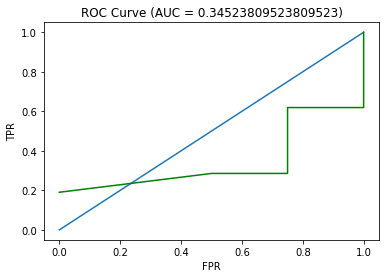

In [171]:
plot_roc_curve(forest_model, x_test, y_test)

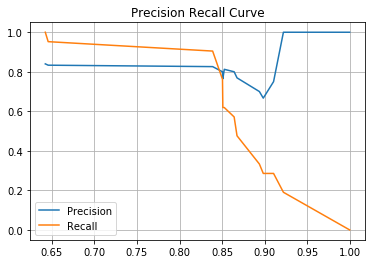

In [172]:
plot_precition_recall(forest_model, x_test, y_test)

In [173]:
forest_model.name = 'forest_show'
with open("models/inner_forest_cht.pkl", "wb") as f:
    pickle.dump(forest_model, f)
modelos.append(forest_model)

## Naive Bayes Model

In [174]:
from sklearn import naive_bayes, metrics

gauss_model = naive_bayes.GaussianNB()
gauss_model.fit(x_train, y_train)
gauss_model.score(x_test,y_test)

0.72

             precision    recall  f1-score   support

          0       0.33      0.75      0.46         4
          1       0.94      0.71      0.81        21

avg / total       0.84      0.72      0.75        25

Training Data Accuracy: 0.88
Test Data Accuracy:     0.72
[[ 3  1]
 [ 6 15]]


Precision:              0.94
Recall:                 0.71


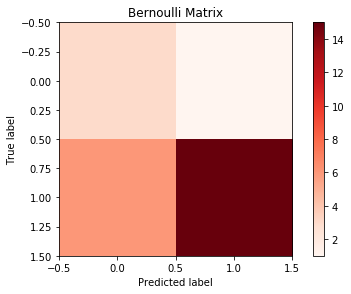

In [175]:
y_pred = gauss_model.predict(x_test)
print(metrics.classification_report(y_test, y_pred))
plot_confussion_matrix('Bernoulli Matrix', gauss_model, x_train, y_train, x_test, y_test)

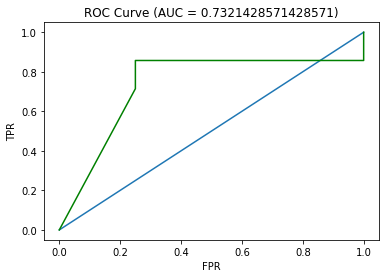

In [176]:
plot_roc_curve(gauss_model, x_test, y_test)

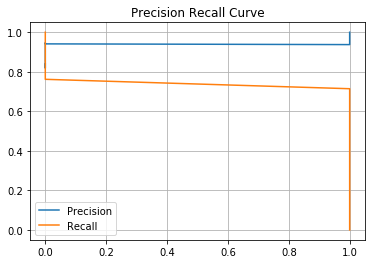

In [177]:
plot_precition_recall(gauss_model, x_test, y_test)

In [178]:
gauss_model.name = 'gaussNB_show'
modelos.append(gauss_model)

No good.  

### Try Naiver Bayes - Bernoulli, but only with Binary variables

In [179]:
x_bin = got_df[['isdead_bk', 'ismale', 'book1', 'book2', 'book3', 'book4', 'book5',
            #'isalivemother_bk', 'isalivefather_bk', 'isaliveheir_bk','isalivespouse_bk', 'ismarried_bk', 
            'isnoble_bk', 'booldeadrelations_bk', 'ispopular_bk', #'death_bk', 'apperance_chp',
            #'hasmom_bk', 'hasdad_bk', 'hasheir_bk', 'hasspouse_bk', 
            #'age_bk', 'numdeadrelations_bk', 'popularity_bk', 
            #'culture_bk', 'house_bk', 'name_y', 'isalive_shw', 'death_season', 
            #'time_s1', 'time_s2', 'time_s3', 'time_s4', 'total_episode_num', 
            'season1', 'season2', 'season3', 'season4', #'age_shw', #'house_shw', 'match_name',
            'culture_bk[T.Astap]', 'culture_bk[T.Braav]', 'culture_bk[T.Crann]', 'culture_bk[T.Dorni]', 
            'culture_bk[T.Dothr]', 'culture_bk[T.Free ]', 'culture_bk[T.Ghisc]', 'culture_bk[T.Ironb]', 
            'culture_bk[T.Ironm]', 'culture_bk[T.Lhaza]', 'culture_bk[T.Lysen]', 'culture_bk[T.Myris]', 
            'culture_bk[T.Naath]', 'culture_bk[T.None]', 'culture_bk[T.North]', 'culture_bk[T.Pento]', 
            'culture_bk[T.Qarth]', 'culture_bk[T.Reach]', 'culture_bk[T.River]', 'culture_bk[T.Storm]', 
            'culture_bk[T.The R]', 'culture_bk[T.Tyros]', 'culture_bk[T.Valem]', 'culture_bk[T.Valyr]', 
            'culture_bk[T.Weste]', 'culture_bk[T.Wildl]',
            'house_bk[T.BROTHERHOOD WITHOUT BANNERS]', 'house_bk[T.HOUSE ARRYN]', 'house_bk[T.HOUSE BAELISH]', 
            'house_bk[T.HOUSE BARATHEON]', 'house_bk[T.HOUSE BOLTON]', 'house_bk[T.HOUSE CLEGANE]', 
            'house_bk[T.HOUSE FREY]', 'house_bk[T.HOUSE GREYJOY]', 'house_bk[T.HOUSE LANNISTER]', 
            'house_bk[T.HOUSE MARTELL]', 'house_bk[T.HOUSE STARK]', 'house_bk[T.HOUSE TARGARYEN]', 
            'house_bk[T.HOUSE TULLY]', 'house_bk[T.HOUSE TYRELL]', 'house_bk[T.NIGHTS WATCH]', 'house_bk[T.OTHER]', 
            'house_bk[T.UNKNOWN]', 'house_shw[T.House Bolton]', 'house_shw[T.House Greyjoy]', 
            'house_shw[T.House Lannister]', 'house_shw[T.House Stark]', 'house_shw[T.House Targaryen]', 
            'house_shw[T.None]', 'house_shw[T.Nights Watch]']]

In [180]:
x_train2, x_test2, y_train2, y_test2 = model_selection.train_test_split(x_bin, y, test_size=0.30, random_state=4444, stratify=y)

In [181]:
bern_model = naive_bayes.BernoulliNB()
bern_model.fit(x_train2, y_train2)
bern_model.score(x_test2,y_test2)

0.84

C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.84      1.00      0.91        21

avg / total       0.71      0.84      0.77        25

Training Data Accuracy: 0.88
Test Data Accuracy:     0.84
[[ 0  4]
 [ 0 21]]


Precision:              0.84
Recall:                 1.00


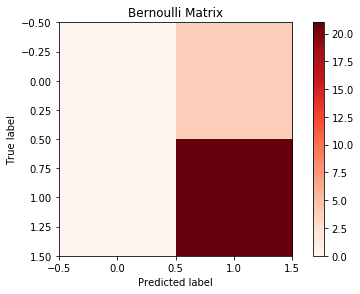

In [182]:
y_pred = bern_model.predict(x_test2)
print(metrics.classification_report(y_test2, y_pred))
plot_confussion_matrix('Bernoulli Matrix', bern_model, x_train2, y_train2, x_test2, y_test2)

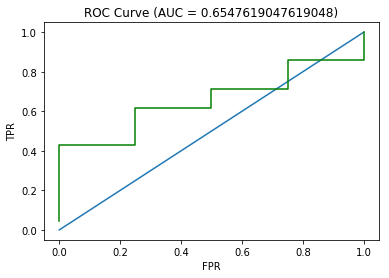

In [183]:
plot_roc_curve(bern_model, x_test2, y_test2)

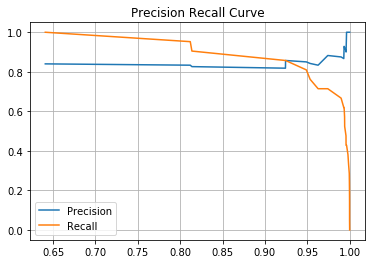

In [184]:
plot_precition_recall(bern_model, x_test2, y_test2)

In [185]:
#bern_model.name = 'bernoulNB_show'
#modelos.append(bern_model)

> So far, best Model is **RANDOM FOREST**

# Analysis on LEFT JOIN
**All Characters from the books, including those with info from Tv Show**

In [33]:
got_df = pd.read_csv('csv/SQL_GOT_data.csv')
total = len(got_df)
total

2011

In [34]:
y = got_df['isdead_shw']
x = got_df[x_test.columns]
len(x)

2011

In [36]:
print('Original dataset shape {}'.format(Counter(y)))

x_train2, x_test2, y_train2, y_test2 = model_selection.train_test_split(x, y, test_size=0.30, random_state=4444, stratify=y)
print('Original dataset train {}'.format(Counter(y_train2)))
print('Original dataset test {}'.format(Counter(y_test2)))

Original dataset shape Counter({0.0: 1946, 1.0: 65})
Original dataset train Counter({0.0: 1362, 1.0: 45})
Original dataset test Counter({0.0: 584, 1.0: 20})


### kNN Model

In [190]:
best_k = 1
max_score = 0

for k in range(1,51) :
    model = KNeighborsClassifier(k)
    model.fit(x_train2, y_train2)
    current_score = accuracy_score(y_test2, model.predict(x_test2))
    if current_score > max_score :
        max_score = current_score
        best_k = k
print('Best k: ' + str(best_k) + '  (Score = ' + str(max_score) + ')')


Best k: 3  (Score = 0.98989898989899)


In [191]:
knn_model_bk = KNeighborsClassifier(best_k)
knn_model_bk.fit(x_train2, y_train2)
knn_model_bk.score(x_test2, y_test2)

0.98989898989899

             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99       573
        1.0       0.80      0.95      0.87        21

avg / total       0.99      0.99      0.99       594

Training Data Accuracy: 0.99
Test Data Accuracy:     0.99
[[568   5]
 [  1  20]]


Precision:              0.80
Recall:                 0.95


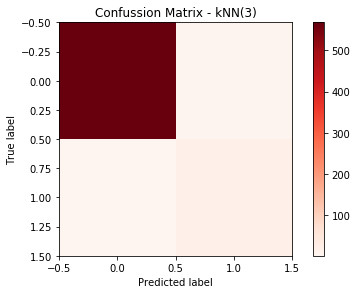

In [192]:
print(classification_report(y_test2, knn_model_bk.predict(x_test2)))
plot_confussion_matrix('Confussion Matrix - kNN('+ str(best_k) +')', knn_model_bk, x_train2, y_train2, x_test2, y_test2)
#plt.savefig('kNN_ConfussionMat.png')

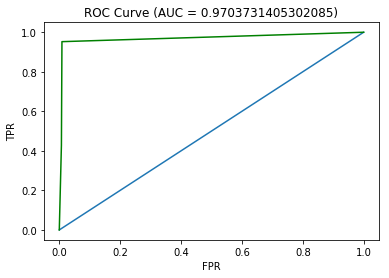

In [193]:
plot_roc_curve(knn_model_bk, x_test2, y_test2)

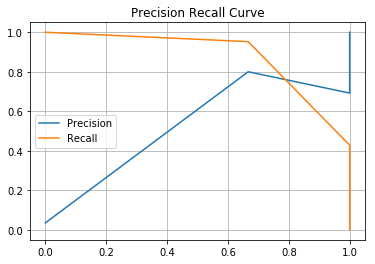

In [194]:
plot_precition_recall(knn_model_bk, x_test2, y_test2)

In [195]:
knn_model_bk.name = 'knn_bk'
with open("models/left_knn6_cht.pkl", "wb") as f:
    pickle.dump(knn_model_bk, f)
modelos.append(knn_model_bk)

### Logistic Regression (Unbalanced)

In [196]:
log_model_bk = LogisticRegression()
log_model_bk.fit(x_train2, y_train2)
log_model_bk.score(x_test2, y_test2)

0.9797979797979798

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       573
        1.0       0.76      0.62      0.68        21

avg / total       0.98      0.98      0.98       594

Training Data Accuracy: 0.99
Test Data Accuracy:     0.98
[[569   4]
 [  8  13]]


Precision:              0.76
Recall:                 0.62


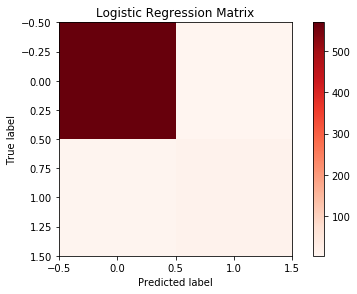

In [197]:
print(classification_report(y_test2, log_model_bk.predict(x_test2)))
plot_confussion_matrix('Logistic Regression Matrix', log_model_bk, x_train2, y_train2, x_test2, y_test2)

**Grid Search**

In [198]:
param_grid = {
    "C": np.logspace(2,-5,10)
}

rbf_grid = model_selection.RandomizedSearchCV(log_model_bk, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=5)

In [199]:
rbf_grid.fit(x_train2, y_train2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.00035938136638046257 ........................................
[CV] ......................... C=0.00035938136638046257, total=   0.0s
[CV] C=0.00035938136638046257 ........................................
[CV] ......................... C=0.00035938136638046257, total=   0.0s
[CV] C=0.00035938136638046257 ........................................
[CV] ......................... C=0.00035938136638046257, total=   0.0s
[CV] C=0.00035938136638046257 ........................................
[CV] ......................... C=0.00035938136638046257, total=   0.0s
[CV] C=0.00035938136638046257 ........................................
[CV] ......................... C=0.00035938136638046257, total=   0.0s
[CV] C=2.7825594022071245 ............................................
[CV] ............................. C=2.7825594022071245, total=   0.0s
[CV] C=2.7825594022071245 ............................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=16.68100537200059 .............................................
[CV] .............................. C=16.68100537200059, total=   0.0s
[CV] C=16.68100537200059 .............................................
[CV] .............................. C=16.68100537200059, total=   0.0s
[CV] C=16.68100537200059 .............................................
[CV] .............................. C=16.68100537200059, total=   0.0s
[CV] C=16.68100537200059 .............................................
[CV] .............................. C=16.68100537200059, total=   0.0s
[CV] C=16.68100537200059 .............................................
[CV] .............................. C=16.68100537200059, total=   0.0s
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   0.0s
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.3s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [200]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")


best params: {'C': 16.68100537200059}
best score: 0.984115523465704



In [201]:
log_model_bk = rbf_grid.best_estimator_
log_model_bk.fit(x_train2, y_train2)
log_model_bk.score(x_test2, y_test2)

0.9848484848484849

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       573
        1.0       0.80      0.76      0.78        21

avg / total       0.98      0.98      0.98       594

Training Data Accuracy: 1.00
Test Data Accuracy:     0.98
[[569   4]
 [  5  16]]


Precision:              0.80
Recall:                 0.76


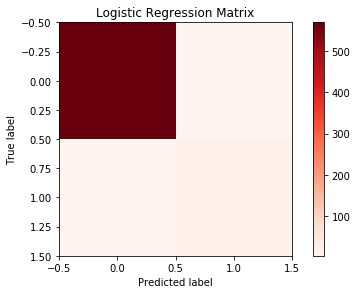

In [202]:
print(classification_report(y_test2, log_model_bk.predict(x_test2)))
plot_confussion_matrix('Logistic Regression Matrix', log_model_bk, x_train2, y_train2, x_test2, y_test2)

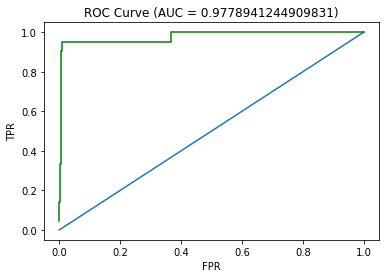

In [203]:
plot_roc_curve(log_model_bk, x_test2, y_test2)

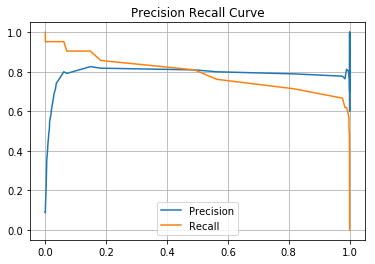

In [204]:
plot_precition_recall(log_model_bk, x_test2, y_test2)

In [205]:
log_model_bk.name = 'RegLog_bk'
with open("models/left_reglog_cht.pkl", "wb") as f:
    pickle.dump(log_model_bk, f)
modelos.append(log_model_bk)

# Logistic Regression (Balanced)

In [37]:
bal_model_bk = LogisticRegression(class_weight='balanced')
bal_model_bk.fit(x_train2, y_train2)
bal_model_bk.score(x_test2, y_test2)

0.9701986754966887

**Grid Search**

In [38]:
param_grid = {
    "C": np.logspace(2,-5,10)
}

rbf_grid = model_selection.RandomizedSearchCV(bal_model_bk, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=5)

In [39]:
rbf_grid.fit(x_train2, y_train2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.01291549665014884 ...........................................
[CV] ............................ C=0.01291549665014884, total=   0.0s
[CV] C=0.01291549665014884 ...........................................
[CV] ............................ C=0.01291549665014884, total=   0.0s
[CV] C=0.01291549665014884 ...........................................
[CV] ............................ C=0.01291549665014884, total=   0.0s
[CV] C=0.01291549665014884 ...........................................
[CV] ............................ C=0.01291549665014884, total=   0.0s
[CV] C=0.01291549665014884 ...........................................
[CV] ............................ C=0.01291549665014884, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=100.0 .........................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......................................... C=100.0, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=0.002154434690031882 ..........................................
[CV] ........................... C=0.002154434690031882, total=   0.0s
[CV] C=0.002154434690031882 ..........................................
[CV] ........................... C=0.002154434690031882, total=   0.0s
[CV] C=0.002154434690031882 ..........................................
[CV] ........................... C=0.002154434690031882, total=   0.0s
[CV] C=0.002154434690031882 ..........................................
[CV] ........................... C=0.002154434690031882, total=   0.0s
[CV] C=0.002154434690031882 ..........................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.5s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [40]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")


best params: {'C': 0.01291549665014884}
best score: 0.9758351101634684



In [41]:
bal_model_bk = rbf_grid.best_estimator_
bal_model_bk.fit(x_train2,y_train2)
bal_model_bk.score(x_test2, y_test2)

0.9701986754966887

In [42]:
print(classification_report(y_test2, bal_model_bk.predict(x_test2)))

             precision    recall  f1-score   support

        0.0       0.99      0.97      0.98       584
        1.0       0.53      0.85      0.65        20

avg / total       0.98      0.97      0.97       604



Training Data Accuracy: 0.98
Test Data Accuracy:     0.97
[[569  15]
 [  3  17]]


Precision:              0.53
Recall:                 0.85


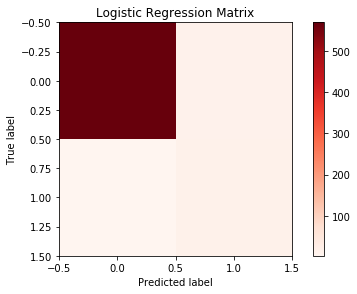

In [43]:
plot_confussion_matrix('Logistic Regression Matrix', bal_model_bk, x_train2, y_train2, x_test2, y_test2)

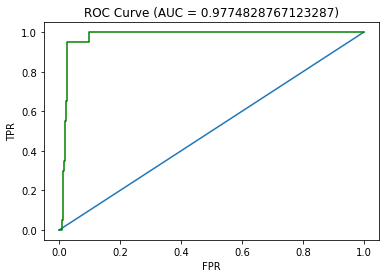

In [44]:
plot_roc_curve(bal_model_bk, x_test2, y_test2)

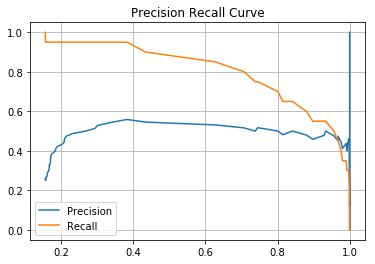

In [45]:
plot_precition_recall(bal_model_bk, x_test2, y_test2)

In [47]:
bal_model_bk.name='RegLog_bk'
with open("models/left_balanced.pkl", "wb") as f:
    pickle.dump(bal_model_bk, f)
#modelos.append(bal_model_bk)

## SVM Model (Lineal)

In [216]:
svm_model_bk = svm.SVC(kernel='linear', probability=True)
svm_model_bk.fit(x_train2, y_train2)
svm_model_bk.score(x_test2, y_test2)

0.9865319865319865

**Grid Search**

In [217]:
param_grid = {
    "C": np.logspace(2, -5, 10),
    "gamma": np.logspace(1, -5, 10),
}

rbf_grid = model_selection.RandomizedSearchCV(
    svm_model_bk, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=2)

In [218]:
rbf_grid.fit(x_train2, y_train2)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] gamma=0.001, C=0.00035938136638046257 ...........................
[CV] ............ gamma=0.001, C=0.00035938136638046257, total=   0.3s
[CV] gamma=0.001, C=0.00035938136638046257 ...........................
[CV] ............ gamma=0.001, C=0.00035938136638046257, total=   0.0s
[CV] gamma=0.001, C=0.00035938136638046257 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ............ gamma=0.001, C=0.00035938136638046257, total=   0.2s
[CV] gamma=0.001, C=0.00035938136638046257 ...........................
[CV] ............ gamma=0.001, C=0.00035938136638046257, total=   0.2s
[CV] gamma=0.001, C=0.00035938136638046257 ...........................
[CV] ............ gamma=0.001, C=0.00035938136638046257, total=   0.3s
[CV] gamma=0.00021544346900318867, C=0.00035938136638046257 ..........
[CV]  gamma=0.00021544346900318867, C=0.00035938136638046257, total=   0.2s
[CV] gamma=0.00021544346900318867, C=0.00035938136638046257 ..........
[CV]  gamma=0.00021544346900318867, C=0.00035938136638046257, total=   0.0s
[CV] gamma=0.00021544346900318867, C=0.00035938136638046257 ..........
[CV]  gamma=0.00021544346900318867, C=0.00035938136638046257, total=   0.7s
[CV] gamma=0.00021544346900318867, C=0.00035938136638046257 ..........
[CV]  gamma=0.00021544346900318867, C=0.00035938136638046257, total=   0.3s
[CV] gamma=0.00021544346900318867, C=0.000359381366380462

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=2, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05]), 'gamma': array([1.00000e+01, 2.15443e+00, 4.64159e-01, 1.00000e-01, 2.15443e-02,
       4.64159e-03, 1.00000e-03, 2.15443e-04, 4.64159e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [219]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")
rbf_grid.best_params_


best params: {'gamma': 0.001, 'C': 0.00035938136638046257}
best score: 0.9848375451263538



{'gamma': 0.001, 'C': 0.00035938136638046257}

In [220]:
svm_model_bk = rbf_grid.best_estimator_
svm_model_bk.fit(x_train2,y_train2)
svm_model_bk.score(x_test2, y_test2)

0.9814814814814815

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       573
        1.0       0.78      0.67      0.72        21

avg / total       0.98      0.98      0.98       594

Training Data Accuracy: 0.99
Test Data Accuracy:     0.98
[[569   4]
 [  7  14]]


Precision:              0.78
Recall:                 0.67


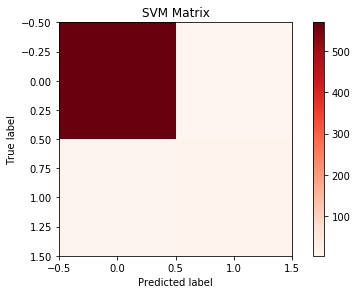

In [221]:
print(classification_report(y_test2, svm_model_bk.predict(x_test2)))
plot_confussion_matrix('SVM Matrix', svm_model_bk, x_train2, y_train2, x_test2, y_test2)

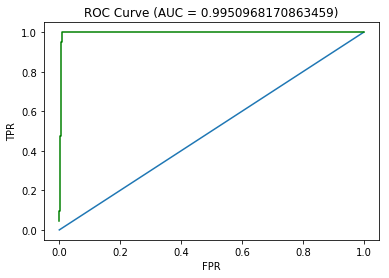

In [222]:
plot_roc_curve(svm_model_bk, x_test2, y_test2)

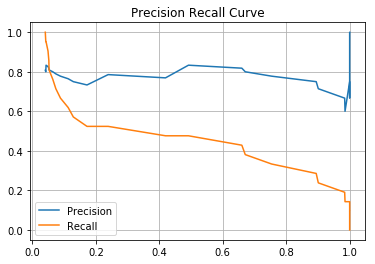

In [223]:
plot_precition_recall(svm_model_bk, x_test2, y_test2)

In [224]:
svm_model_bk.name = 'SvmLin_bk'
modelos.append(svm_model_bk)

## SVM Model (RBF Kernell)

In [225]:
rbf_svm_bk = svm.SVC(kernel='rbf', probability=True)
rbf_svm_bk.fit(x_train2, y_train2)
rbf_svm_bk.score(x_test2, y_test2)

0.98989898989899

In [226]:
param_grid = {
    "C": np.logspace(2,-5,10),
    "gamma": np.logspace(1,-5,10),
}

rbf_grid = model_selection.RandomizedSearchCV(rbf_svm_bk, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=5)

In [227]:
rbf_grid.fit(x_train2, y_train2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] gamma=0.001, C=16.68100537200059 ................................
[CV] ................. gamma=0.001, C=16.68100537200059, total=   0.0s
[CV] gamma=0.001, C=16.68100537200059 ................................
[CV] ................. gamma=0.001, C=16.68100537200059, total=   0.0s
[CV] gamma=0.001, C=16.68100537200059 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................. gamma=0.001, C=16.68100537200059, total=   0.0s
[CV] gamma=0.001, C=16.68100537200059 ................................
[CV] ................. gamma=0.001, C=16.68100537200059, total=   0.0s
[CV] gamma=0.001, C=16.68100537200059 ................................
[CV] ................. gamma=0.001, C=16.68100537200059, total=   0.0s
[CV] gamma=0.001, C=5.994842503189409e-05 ............................
[CV] ............. gamma=0.001, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.001, C=5.994842503189409e-05 ............................
[CV] ............. gamma=0.001, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.001, C=5.994842503189409e-05 ............................
[CV] ............. gamma=0.001, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.001, C=5.994842503189409e-05 ............................
[CV] ............. gamma=0.001, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.001, C=5.994842503189409e-05 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.6s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05]), 'gamma': array([1.00000e+01, 2.15443e+00, 4.64159e-01, 1.00000e-01, 2.15443e-02,
       4.64159e-03, 1.00000e-03, 2.15443e-04, 4.64159e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [228]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")
rbf_grid.best_params_


best params: {'gamma': 0.001, 'C': 16.68100537200059}
best score: 0.9935018050541516



{'gamma': 0.001, 'C': 16.68100537200059}

In [229]:
rbf_svm_bk = rbf_grid.best_estimator_
rbf_svm_bk.fit(x_train2,y_train2)
rbf_svm_bk.score(x_test2, y_test2)

0.9915824915824916

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00       573
        1.0       0.81      1.00      0.89        21

avg / total       0.99      0.99      0.99       594

Training Data Accuracy: 1.00
Test Data Accuracy:     0.99
[[568   5]
 [  0  21]]


Precision:              0.81
Recall:                 1.00


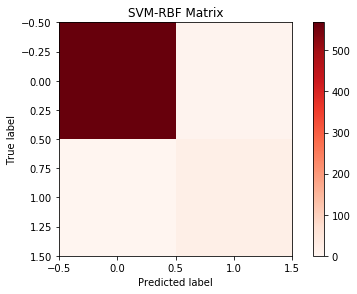

In [230]:
print(classification_report(y_test2, rbf_svm_bk.predict(x_test2)))
plot_confussion_matrix('SVM-RBF Matrix', rbf_svm_bk, x_train2, y_train2, x_test2, y_test2)

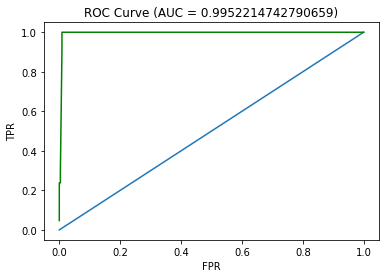

In [231]:
plot_roc_curve(rbf_svm_bk, x_test2, y_test2)

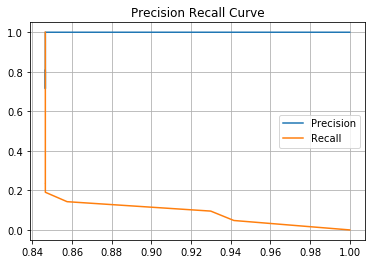

In [232]:
plot_precition_recall(rbf_svm_bk, x_test2, y_test2)

In [233]:
rbf_svm_bk.name = 'SvmRbf_bk'
with open("models/left_svm_rbf_cht.pkl", "wb") as f:
    pickle.dump(rbf_svm_bk, f)
    modelos.append(rbf_svm_bk)

## SVM Model (Polynomial Kernell)

In [234]:
svm_poly_bk = svm.SVC(kernel='poly', probability=True)
svm_poly_bk.fit(x_train2, y_train2)
svm_poly_bk.score(x_test2, y_test2)

0.9848484848484849

**Grid Search**

In [235]:
param_grid = {
    "C": np.logspace(2,-5,10),
    "gamma": np.logspace(1,-5,10),
}

rbf_grid = model_selection.RandomizedSearchCV(svm_poly_bk, param_grid, verbose=2, n_jobs=1, cv=3, n_iter=5)

In [236]:
rbf_grid.fit(x_train2, y_train2)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] gamma=0.00021544346900318867, C=0.46415888336127775 .............
[CV]  gamma=0.00021544346900318867, C=0.46415888336127775, total=   1.2s
[CV] gamma=0.00021544346900318867, C=0.46415888336127775 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  gamma=0.00021544346900318867, C=0.46415888336127775, total=   0.2s
[CV] gamma=0.00021544346900318867, C=0.46415888336127775 .............
[CV]  gamma=0.00021544346900318867, C=0.46415888336127775, total=   0.0s
[CV] gamma=2.154434690031884, C=0.0774263682681127 ...................
[CV] .... gamma=2.154434690031884, C=0.0774263682681127, total=   1.8s
[CV] gamma=2.154434690031884, C=0.0774263682681127 ...................
[CV] .... gamma=2.154434690031884, C=0.0774263682681127, total=   0.2s
[CV] gamma=2.154434690031884, C=0.0774263682681127 ...................
[CV] .... gamma=2.154434690031884, C=0.0774263682681127, total=   0.0s
[CV] gamma=0.00021544346900318867, C=5.994842503189409e-05 ...........
[CV]  gamma=0.00021544346900318867, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.00021544346900318867, C=5.994842503189409e-05 ...........
[CV]  gamma=0.00021544346900318867, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.00021544346900318867, C=5.994842503189409e-05 ......

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    7.0s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05]), 'gamma': array([1.00000e+01, 2.15443e+00, 4.64159e-01, 1.00000e-01, 2.15443e-02,
       4.64159e-03, 1.00000e-03, 2.15443e-04, 4.64159e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [237]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")
rbf_grid.best_params_


best params: {'gamma': 0.021544346900318846, 'C': 1e-05}
best score: 0.9891696750902527



{'gamma': 0.021544346900318846, 'C': 1e-05}

In [238]:
svm_poly_bk = rbf_grid.best_estimator_
svm_poly_bk.fit(x_train2,y_train2)
svm_poly_bk.score(x_test2, y_test2)

0.9848484848484849

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       573
        1.0       0.77      0.81      0.79        21

avg / total       0.99      0.98      0.99       594

Training Data Accuracy: 1.00
Test Data Accuracy:     0.98
[[568   5]
 [  4  17]]


Precision:              0.77
Recall:                 0.81


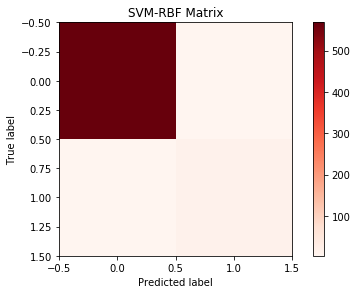

In [239]:
print(classification_report(y_test2, svm_poly_bk.predict(x_test2)))
plot_confussion_matrix('SVM-RBF Matrix', svm_poly_bk, x_train2, y_train2, x_test2, y_test2)

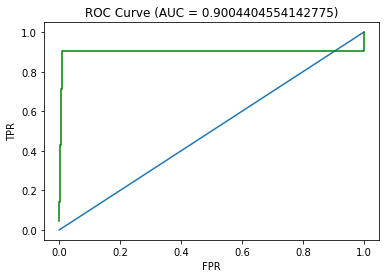

In [240]:
plot_roc_curve(svm_poly_bk, x_test2, y_test2)

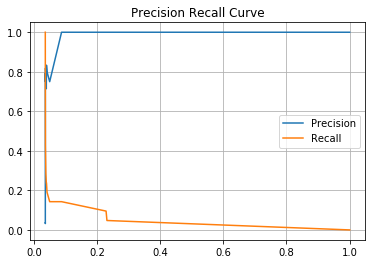

In [241]:
plot_precition_recall(svm_poly_bk, x_test2, y_test2)

In [242]:
svm_poly_bk.name = 'SvmPoly_bk'
modelos.append(svm_poly_bk)

## Decision Tree Model

In [243]:
from sklearn.tree import DecisionTreeClassifier

best_depth = 1
max_score = 0

for d in range(3,50) :
    tree_model_bk = DecisionTreeClassifier(max_depth=d, )
    tree_model_bk.fit(x_train2, y_train2)
    current_score = accuracy_score(y_test2, tree_model_bk.predict(x_test2))
    if current_score > max_score :
        max_score = current_score
        best_depth = d
print('Best Depth: ' + str(best_depth) + '  (Score = ' + str(max_score) + ')')


Best Depth: 10  (Score = 0.98989898989899)


In [244]:
tree_model_bk = DecisionTreeClassifier(max_depth=best_depth)
tree_model_bk.fit(x_train2, y_train2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       573
        1.0       0.86      0.86      0.86        21

avg / total       0.99      0.99      0.99       594

Training Data Accuracy: 1.00
Test Data Accuracy:     0.99
[[570   3]
 [  3  18]]


Precision:              0.86
Recall:                 0.86


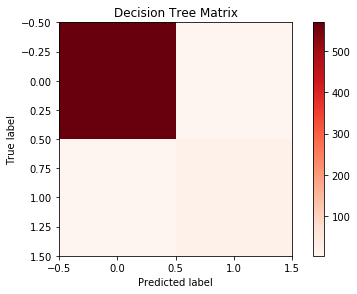

In [245]:
print(classification_report(y_test2, tree_model_bk.predict(x_test2)))
plot_confussion_matrix('Decision Tree Matrix', tree_model_bk, x_train2, y_train2, x_test2, y_test2)

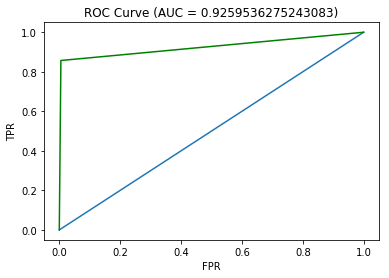

In [246]:
plot_roc_curve(tree_model_bk, x_test2, y_test2)

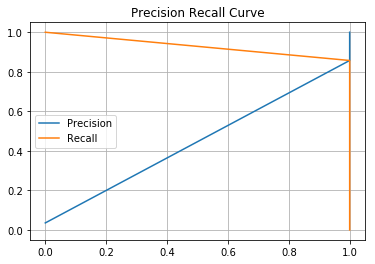

In [247]:
plot_precition_recall(tree_model_bk, x_test2, y_test2)

In [248]:
tree_model_bk.name = 'DecTree_bk'
modelos.append(tree_model_bk)

## Random Forest Model

In [249]:
from sklearn.ensemble import RandomForestClassifier

best_depth = 1
max_score = 0

for d in range(1,50) :
    forest_model_bk = RandomForestClassifier(max_depth=d, max_features=None, n_estimators=30)
    forest_model_bk.fit(x_train2, y_train2)
    #current_score = accuracy_score(y_test2, forest_model_bk.predict(x_test2))
    current_score = forest_model_bk.score(x_test2,y_test2)
    if current_score > max_score :
        max_score = current_score
        best_depth = d
print('Best Depth: ' + str(best_depth) + '  (Score = ' + str(max_score) + ')')

Best Depth: 9  (Score = 0.9915824915824916)


In [250]:
forest_model_bk = RandomForestClassifier(max_depth=best_depth, max_features=None, n_estimators=30)
forest_model_bk.fit(x_train2, y_train2)
forest_model_bk.score(x_test2,y_test2)

0.98989898989899

             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99       573
        1.0       0.80      0.95      0.87        21

avg / total       0.99      0.99      0.99       594

Training Data Accuracy: 1.00
Test Data Accuracy:     0.99
[[568   5]
 [  1  20]]


Precision:              0.80
Recall:                 0.95


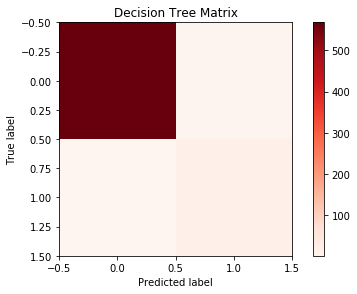

In [251]:
print(classification_report(y_test2, forest_model_bk.predict(x_test2)))
plot_confussion_matrix('Decision Tree Matrix', forest_model_bk, x_train2, y_train2, x_test2, y_test2)

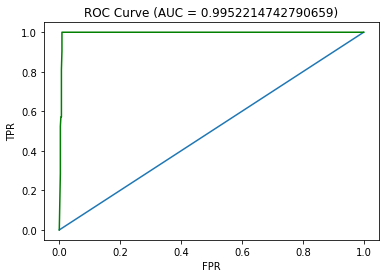

In [252]:
plot_roc_curve(forest_model_bk, x_test2, y_test2)

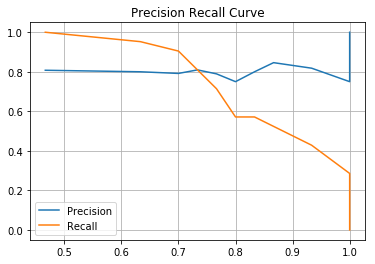

In [253]:
plot_precition_recall(forest_model_bk, x_test2, y_test2)

In [254]:
forest_model_bk.name = 'Forest_bk'
modelos.append(forest_model_bk)

In [255]:
sorted(zip(x.columns, forest_model_bk.feature_importances_), key=lambda tup: tup[1], reverse=True)
zipped = sorted(zip(x.columns, forest_model_bk.feature_importances_), key=lambda tup: tup[1], reverse=True)
zipped

[('season2', 0.3279030992044788),
 ('time_s2', 0.20556529177146907),
 ('time_s4', 0.11133625398289086),
 ('time_s1', 0.09647936837335516),
 ('season3', 0.0753196497269433),
 ('time_s3', 0.06504609871849582),
 ('season1', 0.03956556615707844),
 ('season4', 0.024235432771030633),
 ('ismale', 0.014263786967046164),
 ('popularity_bk', 0.00625212591984209),
 ('age_bk', 0.005005432389517687),
 ('house_bk[T.HOUSE TYRELL]', 0.004958976452377352),
 ('culture_bk[T.North]', 0.0046995196231088355),
 ('house_shw[T.House Stark]', 0.002072860877939117),
 ('age_shw', 0.0018426196039728498),
 ('house_bk[T.UNKNOWN]', 0.001761104863393884),
 ('numdeadrelations_bk', 0.0014952214652560432),
 ('culture_bk[T.Pento]', 0.0014104344459593672),
 ('culture_bk[T.Valem]', 0.001385505745185144),
 ('culture_bk[T.Astap]', 0.0013749948373499889),
 ('book2', 0.0011925292409546463),
 ('house_bk[T.HOUSE STARK]', 0.0011233514372999197),
 ('book5', 0.0010422916067020802),
 ('culture_bk[T.Braav]', 0.0009221806075738654),
 ('

([], <a list of 0 Text xticklabel objects>)

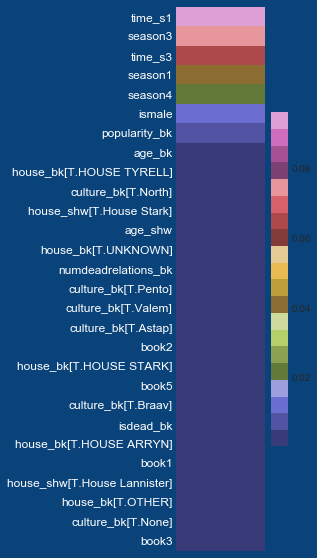

In [256]:
sns.set_style("dark")
fig = plt.figure(figsize=(2, 10))
fig.patch.set_facecolor('xkcd:twilight blue')
important_val = pd.DataFrame(j for i,j in zipped[3:] if j>0)
important_col = pd.DataFrame(i for i,j in zipped[3:] if j>0)
                             
sns.heatmap(important_val, yticklabels=important_col[0], cmap='tab20b')
plt.yticks(fontsize=12, color='white')
plt.xticks([])

In [257]:
with open("models/left_forest_cht.pkl", "wb") as f:
    pickle.dump(forest_model_bk, f)

## Graficarlas todas

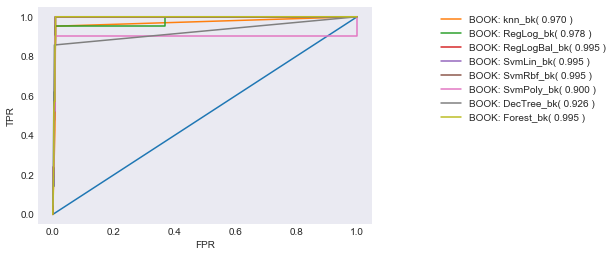

In [258]:
plt.figure()
ax = plt.subplot(111)

# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

# for model in modelos[:9] :
#     y_score=model.predict_proba(x_test)[:,1]
#     fpr, tpr,_ = roc_curve(y_test, y_score)
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr,tpr, label='SHOW: '+model.name+ '( %0.3f' %(roc_auc) +' )')
# ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), shadow=True, ncol=1)

for model in modelos[9:] :
    y_score2=model.predict_proba(x_test2)[:,1]
    fpr, tpr,_ = roc_curve(y_test2, y_score2)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label='BOOK: '+model.name+ '( %0.3f' %(roc_auc) +' )')
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), shadow=True, ncol=1)

### Solo las que sirven:

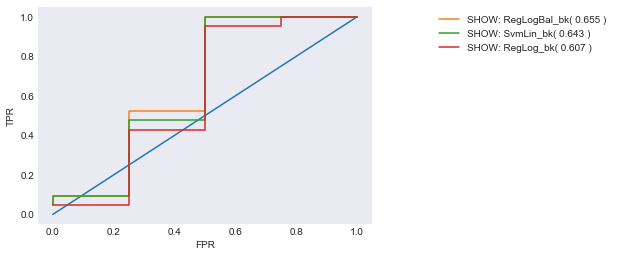

In [290]:
good_models = [bal_model_bk, svm_model_bk, log_model_bk]#, forest_model_bk]#rbf_svm_bk]
plt.figure()
ax = plt.subplot(111)

# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

for model in good_models[:3] :
    y_score=model.predict_proba(x_test)[:,1]
    fpr, tpr,_ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label='SHOW: '+model.name+ '( %0.3f' %(roc_auc) +' )')
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), shadow=True, ncol=1)

for model in good_models[3:] :
    y_score2=model.predict_proba(x_test2)[:,1]
    fpr, tpr,_ = roc_curve(y_test2, y_score2)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label='BOOK: '+model.name+ '( %0.3f' %(roc_auc) +' )')
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), shadow=True, ncol=1)


In [291]:
coef_df = pd.DataFrame()

for model in good_models :
    print(model.name)
    coef_list = sorted(zip(x.columns, model.coef_[0]), key=lambda tup: tup[1], reverse=True)
    if (len(coef_df) == 0) :
        coef_df = pd.DataFrame(coef_list)
    else :
        coef_df = pd.merge(coef_df, pd.DataFrame(coef_list), how='inner', on=0)
    coef_df.rename(columns={1:model.name}, inplace=True)
coef_df.rename(columns={0:'Feature'}, inplace=True)
coef_df.index=coef_df['Feature']
coef_df.drop('Feature', axis=1, inplace=True)
coef_df

RegLogBal_bk
SvmLin_bk
RegLog_bk


,RegLogBal_bk,SvmLin_bk,RegLog_bk
Feature,,,
time_s2,1.302912e-02,4.153918e-03,-0.008296
time_s1,8.055017e-03,1.643783e-03,0.002441
time_s3,7.091023e-03,1.875238e-03,-0.005566
time_s4,6.977258e-03,1.106088e-03,-0.000708
numdeadrelations_bk,2.234151e-04,-1.368601e-05,-0.068449
season2,1.938860e-04,4.081373e-03,10.518905
season1,1.435268e-04,2.818105e-03,3.412397
season4,1.258935e-04,1.722250e-03,4.263223
ispopular_bk,1.230075e-04,-1.158143e-04,0.909230


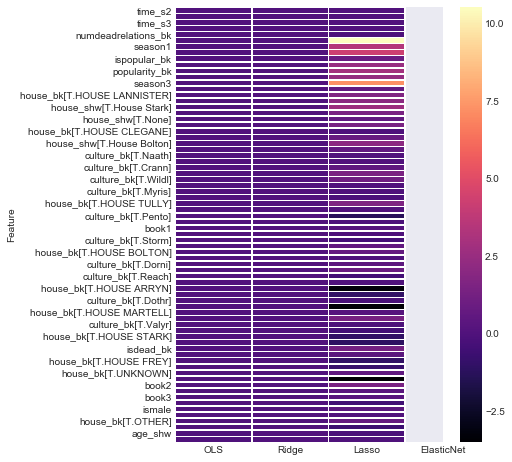

In [294]:
plt.subplots(figsize=(6, 8))
#labels=['OLS', 'Ridge', 'Lasso', 'ElasticNet']
sns.heatmap(coef_df, annot=False, linewidths=.5, cmap='magma', xticklabels=labels)